# RNN
RNN with some bonus stuffs re: helper class that generates the data

In [26]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import matplotlib.pyplot as plt

In [27]:
# this awesome idea of excapsulating the logic of fetching the test data
# basically we just generate y = sin(x), where x = time

class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        # random starting point
        rand_start = np.random.rand(batch_size,1)
        
        # convert to time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        
        # create the batch time series on the x axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # create the Y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)
        
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)

In [28]:
tsd = TimeSeriesData(250,0,10)

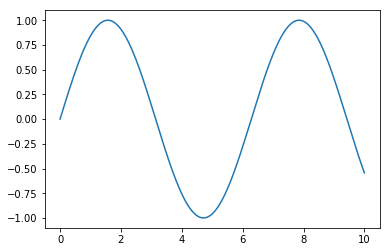

In [29]:
plt.plot(tsd.x_data,tsd.y_true)

In [5]:
num_time_steps = 30

In [6]:
y1,y2,ts = tsd.next_batch(1,num_time_steps,True)

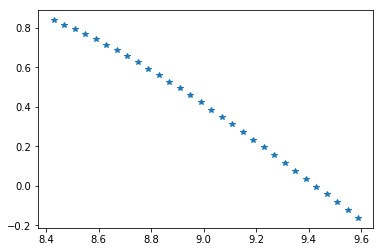

In [7]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

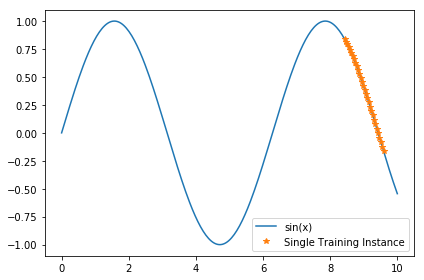

In [8]:
plt.plot(tsd.x_data,tsd.y_true,label='sin(x)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label="Single Training Instance")

plt.legend()
plt.tight_layout()

## Training Data

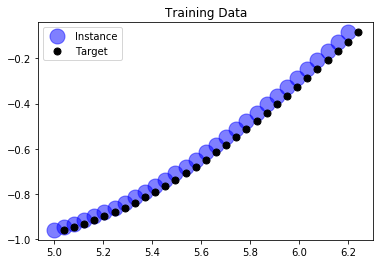

In [9]:
train_inst = np.linspace(5, 5 + tsd.resolution*(num_time_steps+1), num_time_steps+1)
plt.title('Training Data')
plt.plot(train_inst[:-1],tsd.ret_true(train_inst[:-1]),'bo',markersize=15,alpha=0.5,label='Instance')
plt.plot(train_inst[1:],tsd.ret_true(train_inst[:-1]),'ko',markersize=7,label='Target')
plt.legend()

## Model

In [10]:
# hyperparameters
num_neurons = 100
learning_rate = 0.0001
num_train_iterations = 2000
batch_size = 1

num_inputs = 1
num_outputs = 1

# placeholders
X = tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])
y = tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

In [ ]:
# model
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=num_neurons,activation=tf.nn.relu)

# code below does not work sorry. they removed the contrib stuffs from TF2
# I am only running this in compat mode
#cell = tf.nn.rnn_cell.OutputProjectionWrapper(cell,output_size=num_outputs)

In [ ]:
# unrolls the RNN
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [13]:
# standard stuffs
loss = tf.reduce_mean(tf.square(outputs-y))

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [14]:
# if you are using GPU: in case you get the bug where TF (low level) overallocates memory 
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fractions=0.85) 

In [15]:
saver = tf.train.Saver()

In [16]:
# add the gpu options for you RK
#with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:

with tf.Session() as sess:
    sess.run(init)
    for iteration in range(num_train_iterations):
        X_batch, y_batch = tsd.next_batch(batch_size,num_time_steps)
        sess.run(train,feed_dict={X:X_batch,y:y_batch})
        
        # calculate the performance every 100 iteration
        if iteration%100 == 0:
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration,"\tMSE ",mse)
    
    saver.save(sess,"./model/rnn_time_series_model_codealong")
            

0 	MSE  0.2348693
100 	MSE  0.1581837
200 	MSE  0.1406726
300 	MSE  0.20060857
400 	MSE  0.33390766
500 	MSE  0.26732415
600 	MSE  0.26012808
700 	MSE  0.19286592
800 	MSE  0.13621789
900 	MSE  0.13695812
1000 	MSE  0.39804754
1100 	MSE  0.093492776
1200 	MSE  0.08669651
1300 	MSE  0.8399445
1400 	MSE  0.23268081
1500 	MSE  0.15257964
1600 	MSE  0.40516564
1700 	MSE  0.7700852
1800 	MSE  0.2242913
1900 	MSE  0.22546622


In [ ]:
with tf.Session() as sess:
    saver.restore(sess,"./model/rnn_time_series_model_codealong")
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
    y_pred = sess.run(outputs,feed_dict={X:X_new})

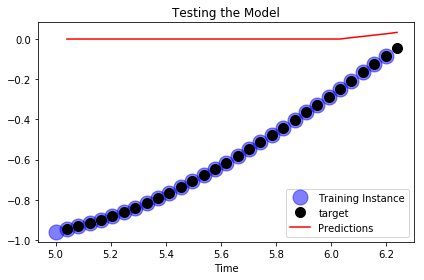

In [30]:
plt.title("Testing the Model")

plt.plot(train_inst[:-1],np.sin(train_inst[:-1]),"bo",markersize=15,alpha=0.5,label="Training Instance")

plt.plot(train_inst[1:],np.sin(train_inst[1:]),"ko",markersize=10,label="target")

plt.plot(train_inst[1:],y_pred[0,:,0],"r",markersize=10,label="Predictions")

plt.xlabel('Time')
plt.legend()
plt.tight_layout()

In [ ]:
# note: our training didnt work. must be an issue with the missing library
#cell = tf.nn.rnn_cell.OutputProjectionWrapper(cell,output_size=num_outputs)